El objetivo es trucar la red neuronal **Inception V3** con un ataque adversario. Pero antes, probemos si funciona la red neuronal con una imágen.

In [1]:
import tensorflow as tf # plataforma para el aprendizaje automatico 
# Desabilitamos eager-execution por que peta cuando usemos más adelante keras.gradients()
tf.compat.v1.disable_eager_execution()
import keras # deep learning framework/api

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions # importamos la red neuronal ya entrenada
from keras import backend as k

In [3]:
iv3 = InceptionV3() # Cargamos la red neuronal, la primera vez se descarga de internet

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# print(iv3.summary()) # Ver resumen de la red neuronal

from keras.preprocessing import image

# Para introducir la imágen a InceptionV3, la imagen requiere de unos requisitos
# Cargamos la imagen con dimension 299x299 (para iv3) y la convertimos a una matriz de datos
coche_2 = image.img_to_array(image.load_img("./img/Notebook_2/coche_2.jpg", target_size=(299,299)))

# Cambiamos el rango o base, de [0-255] a [-1-1], por que
# así espera iv3 que pases los datos de la imágen
coche_2 /= 255
coche_2 -= 0.5
coche_2 *= 2

# La red neuronal espera que como entrada le pasemos un tensor,
# este tiene una dimensión más que la imágen que le pasamos,
# la primera dimensión hace referencia al tamaño del lote o "badge size?"
# esto es útil si queremos meter varias imágenes

coche_2 = coche_2.reshape([1, coche_2.shape[0], coche_2.shape[1], coche_2.shape[2]])

# LISTO, la variable ya esta lista para pasarsela al modelo
resultado = iv3.predict(coche_2)
decode_predictions(resultado)

[[('n04285008', 'sports_car', 0.8140701),
  ('n03459775', 'grille', 0.089450285),
  ('n02974003', 'car_wheel', 0.042520903),
  ('n03100240', 'convertible', 0.016252259),
  ('n04037443', 'racer', 0.0022947474)]]

Ahora, pasemos a romper el modelo con un `Ataque Adversario`. El objetivo es generar una imágen que truque a la red neuronal pero que a su vez, los cambios no sean perceptibles por el ojo humano. 

In [6]:
# Queremos hacer un grafo que represente un proceso de optimización en el que vamos a maximizar la probabilidad
# de que cierta clase aparezca. Queremos que prediga una clase concreta, del palo, le damos un gato
# y queremos que la red identifique que el gato es un limón. 

# Para ello solo necesitamos el punto de entrada y salida de la red neuronal:
input_layer = iv3.layers[0].input # Primera capa de la red neuronal, en concreto el punto de entrada
out_layer = iv3.layers[-1].output # Última capa de la red neuronal, el punto de salida vamos

target_class = 951 # Referencia a la clase limon (porque lo dice DotCSV)

# La función de coste es la probabilidad de la clase 951, osea, de todo el vector de probabilidades
# que devuelve le pedimos la fila 0, columna 951 que es el que nos interesa maximizar (el limon)
loss = out_layer[0, target_class]

# Gradiente sobre la variable de entrada, 
gradiente = k.gradients(loss, input_layer)[0] # Calcular el gradiente del coste respecto al tensor de entrada

# A estas funciones le suministramos los valores de entrada y salida, nuestra entrada es 
# el input_layer y le decimos también que estamos en la fase de entrenamiento y la salida
# es el gradiente y el coste.
optimize_gradient = k.function([input_layer, k.learning_phase()], [gradiente, loss])

copy_coche_2 = np.copy(coche_2) # Copia para no modificar la imágen original
cost = 0.0

# Minimicemos los cambios en la imágen para que no sean perceptibles
# por el ojo humano (de lo contrario apareceran pixeles muy saturados, 
# y se nota que la imágen ha sido modificada).
max_perturb = coche_2 + 0.01
min_perturb = coche_2 - 0.01

In [7]:
while cost < 0.95:
    new_grad, cost = optimize_gradient([copy_coche_2, 0])
    copy_coche_2 += new_grad
    # Los valores fuera del rango, se redondean al min o max especificado
    # Ej: [3, 2, 5, 2, 1, -2] con rango [0, 2] -> [2, 2, 2, 2, 1, 0]
    copy_coche_2 = np.clip(copy_coche_2, min_perturb, max_perturb)
    copy_coche_2 = np.clip(copy_coche_2, -1, 1)
    # print("Verbose:", cost)

In [8]:
# Anteriormente reformateamos la matriz de la imágen para
# que la red neuronal la entendiese, ahora para mostrarla por
# pantalla hay que volver a darle el formato normal
copy_coche_2 /= 2
copy_coche_2 += 0.5
copy_coche_2 *= 255

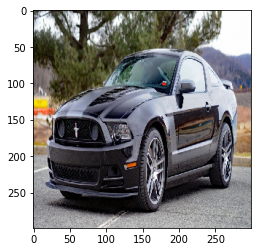

In [9]:
plt.imshow(copy_coche_2[0].astype(np.uint8))
plt.show()

from PIL import Image
# Importante guardarlo con png, si se guarda con jpg se pierde
# calidad en los píxeles y la red neuronal es capaz de identificar
# correctamente que hay en la foto
Image.fromarray(copy_coche_2[0].astype(np.uint8)).save("lemon.png")